### Author: Trent Resh

## Introduction

The goal of this assignment is to be able to use a machine learning model to classify cancerous cell growth in pathology images. A dataset of 7gbs of imagery is provided, which consists of such images. Within the dataset are also corresponding labels for each image, a 1 or a 0, where 1 signifies cancer and 0 otherwise.

Each image is a Tif Image, with dimensions 93x93 pixels. Since color variation is important for classifying cancer, the images are also colored, which means that there are 3 additional dimensions that correspond to each image - those being the red, green, and blue values.

To perform the classification, I will be using 4 different models - the first is a Logistic Regression Classifier. This will help provide us with a baseline of how well any ordinary classifier performs for this problem. The next 3 models will all be convolutional neural networks - these should outperform the LR classifier with ease.

## Step 1. Prepare our environment
Lets start by getting our imports and some helper functions out of the way.

In [13]:
# References source [1]

from glob import glob 
import numpy as np
import tqdm
import pandas as pd
import keras,cv2,os
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model 
from keras.preprocessing.image import load_img
from PIL import Image as im
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import gc

# load labels & filenames
path = "/kaggle/input/cancer/" 
train_path = path + 'train/'
test_path = path + 'test/'
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # filenames
df['id'] = df.path.map(lambda x: x.split('/')[5].split(".")[0])
labels = pd.read_csv(path + "train_labels.csv")
df = df.merge(right=labels)

`load_data` will allow us return dataframes of our targets and our labels.
`data_munge` will return a dataframe that has parity - since about 60% of the data was negative, this will allow us to have a uniform distribution of positive and negative samples. This just iterates through the original dataframe and selects positive and negative samples, along with their corresponding ids. I know there are better ways to do this but I am too unfamiliar with pandas!

In [14]:
# References source [1]

#helper functions for data management
def load_data(N, df, idx):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = []
    for i in df.values:
        y.append(i[2+idx])
    y = np.asarray(y)
    ids = []
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
        ids.append(row["id"])
    return (X, y, ids)

def data_munge(data, labels, ids, df):
    pos_data = []
    neg_data = []
    cached_ids = {}
    for i in range(len(data)-1):
        if labels[i] == 1:
            pos_data.append(ids[i])
            cached_ids[ids[i]] = i
        elif labels[i] == 0:
            neg_data.append(ids[i])
            cached_ids[ids[i]] = i

    neg_data = neg_data[:len(pos_data)]
    id_data = neg_data + pos_data
    parity_df = pd.DataFrame(columns=df.columns)
    for _id in id_data:
        parity_df = parity_df.append(df.iloc[[cached_ids[_id]]])
    parity_df = parity_df.reset_index()
    return (parity_df, id_data)

## Step 2: Exploratory Data Analysis

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/85000 [00:00<?, ?it/s]

  0%|          | 0/68620 [00:00<?, ?it/s]

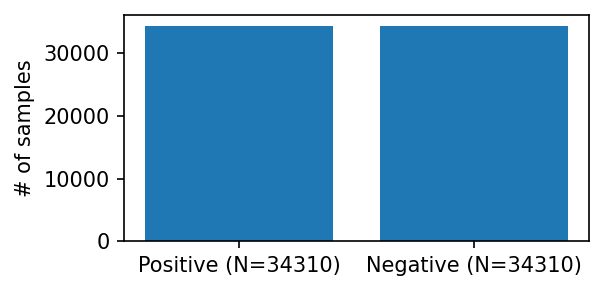

In [15]:
# References source [1]

X, y, ids = load_data(85000,df, 0)
parity_df, ids = data_munge(X, y, ids, df)
X, y, ids = load_data(len(ids),parity_df, 1)
ids = None
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

plt.show()


Great, now that we have parity amongst our samples, let's take a look around to get a better understanding of what we are dealing with here.

We can start by looking at our tif images for cancerous and non cancerous cell growth.

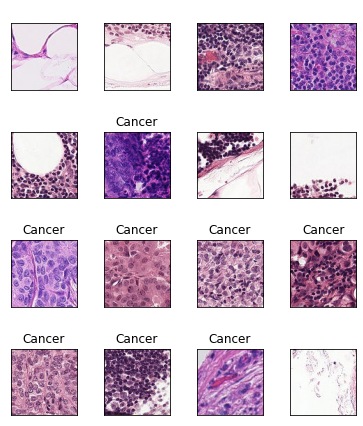

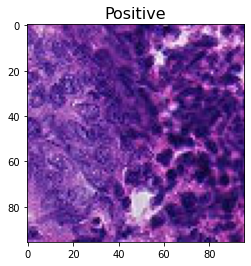

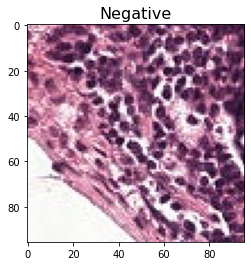

In [21]:
# References source [1]

num_imgs = 4
sample = parity_df.sample(n=(num_imgs**2)+1, axis=0)
sample = sample.reset_index()
index = 1
for _ in range(num_imgs):
    for _ in range(num_imgs):
        ax = plt.subplot(num_imgs, num_imgs, index)
        ax.set_xticks([])
        ax.set_yticks([])
        img = im.open(sample["path"][index])
        plt.imshow(img)
        if sample["label"][index] == 0:
            a = " "
        else:
            a = "Cancer"
        ax.set_title(a)
        index += 1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

#get first pos and negative images
pos = None
neg = None
for index, row in sample.iterrows():
    if row["label"] == 1:
        pos = row
        break
for index, row in sample.iterrows():
    if row["label"] == 0:
        neg = row
        break
plt.imshow(im.open(pos["path"]))
plt.title('Positive',fontsize=16)
plt.show()
plt.title('Negative',fontsize=16)
plt.imshow(im.open(neg["path"]))
plt.show()

With the human eye, it would be difficult to interpret the results but it is worth getting some visual context about cancerous vs non cancerous scans. It appears that it may have something to do with the size of the cells and perhaps how they are structured within the tissue. In our positive image, it looks like there are very large cells amongst the more granular ones.

Since I’m not a doctor or trained to interpret scan results, I don’t have any frame of reference for why one is cancerous while the other isn’t - but hopefully that is something that our CNN model can figure out.

Now let's check the mean brightness amongst our positive and negative samples. __ref[1]__.

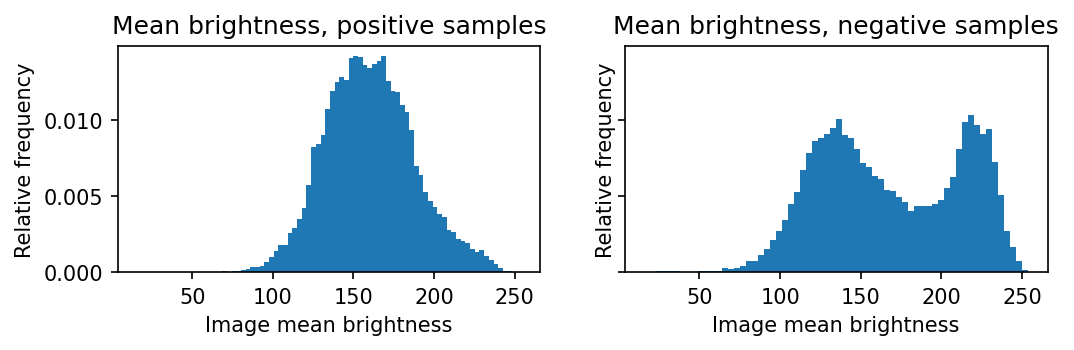

In [22]:
# References source [1]

positive_samples = X[y == 1]
negative_samples = X[y == 0]
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
pos_mean = np.mean(positive_samples,axis=(1,2,3))
neg_mean = np.mean(negative_samples,axis=(1,2,3))
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

As suggested in the reference above and the referenced code, the positives resemble a normal distribution, while the negatives appear to resemble a bimodal distribution in brightness. Maybe even half of the negative samples have a brightness that is higher than the most of the positive samples. Let's run some basic description:

In [23]:
from scipy import stats
pos_stats = stats.describe(pos_mean)
neg_stats = stats.describe(neg_mean)
print("Positive")
print("mean:{0} | variance:{1} | min and max: {2}".format(pos_stats.mean, pos_stats.variance, pos_stats.minmax))
print("-------")
print("Negative")
print("mean:{0} | variance:{1} | min and max: {2}".format(neg_stats.mean, neg_stats.variance, neg_stats.minmax))

Positive
mean:160.4685661654327 | variance:759.9563208841444 | min and max: (62.89362702546296, 248.45232928240742)
-------
Negative
mean:168.77547553091975 | variance:1933.1299949628324 | min and max: (15.619176793981481, 253.93587239583334)


As we can see in the graphs as well as the data, there seems to be some major differences in the variances of the two distributions while the means remain fairly close.

Just to establish a baseline for a classifier, let's go ahead and run our mean brightness values this through a Logistic Regression classifier and see how it performs.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
lr_x = np.mean(X,axis=(1,2,3))
lr_y = y

lr = LogisticRegression()

lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(lr_x, lr_y, test_size=0.2, random_state=2)

logreg = LogisticRegression()
logreg.fit(lr_x_train.reshape(-1, 1), lr_y_train.reshape(-1, 1))
y_pred = logreg.predict(lr_x_test.reshape(-1, 1))
y_pred_proba = logreg.predict_proba(lr_x_test.reshape(-1, 1))[:, 1]
print('Train/Test split results:')
print("LogReg accuracy: {0}".format(accuracy_score(lr_y_test, y_pred)))
print("LogReg loss: {0}".format(log_loss(lr_y_test, y_pred_proba)))

Train/Test split results:
LogReg accuracy: 0.532279218886622
LogReg loss: 0.6869326838192035


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The results of our Logistic Regresssion were very poor. It performed marginally better than a coin toss with a 50% accuracy with an accuracy of about 53%. There was also substantial loss. The constraints of this problem do not appear to be well suited for a Logistic Regression classifier.

## Step 3: Convolutional Neural Network Declaration and Compilation

Below is how we wil define our models. They are based off the model presented in __reference [1]__, however I have added some changes of my own. These changes include adding 2 extra layers (total of 4 hidden layers) with progressively increasing filters, and one of the models will utilize the softmax activation function. I will also train them on 10 epochs rather than 5. From my resesarch, it appears that RELU seems to be the best performing activation function, however I wanted to investigate it would perform versus softmax.

Training will be performed with batch sizes of 50. We will also perform the standard 80-20 train-test split that we used for our Logistic Regression classifier.


## Softmax Model

In [25]:
# References to source [1]

training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

kernel_size = (3, 3)
pool_size= (2, 2)

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
first_filter = 32
second_filter = 64
third_filter = 128
fourth_filter = 256
fifth_filter = 512

# 1st layer 
model.add(Conv2D(first_filter, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("softmax"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# 2nd layer 
model.add(Conv2D(second_filter, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("softmax"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# 3rd layer 
model.add(Conv2D(third_filter, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("softmax"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#4th later
model.add(Conv2D(fourth_filter, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("softmax"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#5th later
model.add(Conv2D(fifth_filter, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("softmax"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# end layer
model.add(Flatten())
model.add(Dense(512, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("softmax"))
model.add(Dropout(dropout_dense))

model.add(Dense(1, activation = "sigmoid"))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

### RELU MODEL

In [26]:
# References source [1]

relu_model = Sequential()

# 1st layer 
relu_model.add(Conv2D(first_filter, kernel_size, input_shape = (96, 96, 3)))
relu_model.add(BatchNormalization())
relu_model.add(Activation("relu"))
relu_model.add(MaxPool2D(pool_size = pool_size)) 
relu_model.add(Dropout(dropout_conv))

# 2nd layer 
relu_model.add(Conv2D(second_filter, kernel_size, use_bias=False))
relu_model.add(BatchNormalization())
relu_model.add(Activation("relu"))
relu_model.add(MaxPool2D(pool_size = pool_size)) 
relu_model.add(Dropout(dropout_conv))

# 3rd layer 
relu_model.add(Conv2D(third_filter, kernel_size, use_bias=False))
relu_model.add(BatchNormalization())
relu_model.add(Activation("relu"))
relu_model.add(MaxPool2D(pool_size = pool_size)) 
relu_model.add(Dropout(dropout_conv))

#4th later
relu_model.add(Conv2D(fourth_filter, kernel_size, use_bias=False))
relu_model.add(BatchNormalization())
relu_model.add(Activation("relu"))
relu_model.add(MaxPool2D(pool_size = pool_size)) 
relu_model.add(Dropout(dropout_conv))

#5th later
relu_model.add(Conv2D(fifth_filter, kernel_size, use_bias=False))
relu_model.add(BatchNormalization())
relu_model.add(Activation("relu"))
relu_model.add(MaxPool2D(pool_size = pool_size)) 
relu_model.add(Dropout(dropout_conv))

# end layer
relu_model.add(Flatten())
relu_model.add(Dense(512, use_bias=False))
relu_model.add(BatchNormalization())
relu_model.add(Activation("relu"))
relu_model.add(Dropout(dropout_dense))

relu_model.add(Dense(1, activation = "sigmoid"))

relu_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

def run_model(model, split_idx, X, y):
    batch_size = 50
    epochs = 10 #how many epochs we want to perform
    for epoch in range(epochs):
        #compute how many batches we'll need
        iterations = np.floor(split_idx / batch_size).astype(int) #the floor makes us discard a few samples here, I got lazy...
        loss,acc = 0,0 #we will compute running loss and accuracy
        with trange(iterations) as t: #display a progress bar
            for i in t:
                start_idx = i * batch_size #starting index of the current batch
                x_batch = X[start_idx:start_idx+batch_size] #the current batch
                y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

                metrics = model.train_on_batch(x_batch, y_batch) #train the model on a batch

                loss = loss + metrics[0] #compute running loss
                acc = acc + metrics[1] #compute running accuracy
                t.set_description('Running training epoch ' + str(epoch)) #set progressbar title
                t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) #display metrics
                
def validate_model(model, split_idx, X, y):
    batch_size = 50
    #compute how many batches we'll need
    iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) #as above, not perfect
    loss,acc = 0,0 #we will compute running loss and accuracy
    with trange(iterations) as t: #display a progress bar
        for i in t:
            start_idx = i * batch_size #starting index of the current batch
            x_batch = X[start_idx:start_idx+batch_size] #the current batch
            y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

            metrics = model.test_on_batch(x_batch, y_batch) #compute metric results for this batch using the model

            loss = loss + metrics[0] #compute running loss
            acc = acc + metrics[1] #compute running accuracy
            t.set_description('Running training') #set progressbar title
            t.set_description('Running validation')
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))

    print("Validation loss:",loss / iterations)
    print("Validation accuracy:",acc / iterations)

## Step 4: Running and evaluating our models

Now that we have our model declarations, lets run them and see how well they perform on classifying our imagery.

In [ ]:
print("--- With softmax --- ")
run_model(model, split_idx, X, y)
validate_model(model, split_idx, X, y)
print("--------------------- ")
print(" ")
print("--------------------- ")
print("--- With RELU --- ")
run_model(relu_model, split_idx, X, y)
validate_model(relu_model, split_idx, X, y)

  0%|          | 0/1097 [00:00<?, ?it/s]

--- With softmax --- 


Running validation:  77%|███████▋  | 211/274 [00:03<00:00, 64.68it/s, acc=0.91, loss=0.24]

#### Results from our Softmax and RELU models

It appears that our Softmax model was able to squeeze out a little more performance than our RELU model! The Softmax model was 2% more accurate - It also had a substantially lower loss. Both models also completely outclassed the Logistic Regression model to no surprise. Now let's see if we can get some more better performance out of our RELU model by tuning hyperparameters. It is worth mentioning that RELU model's total training time was also a bit lower than that of the softmax model


## Step 5: Tuning model hyperparameters


We will first declare another helper function to build a hyperparamterized model. The main diffrence will be that we will be tuning the filter as we go along. A for the architecture of the model, everything will remain the same as the above RELU model. It will also have 4 hidden layers.

In [ ]:
# References sources [2] and sources [3]

def build_model(hp):
    kernel_size = (3, 3)
    pool_size= (2, 2)

    dropout_conv = 0.3
    dropout_dense = 0.5

    model = Sequential()

    for i in range(4):
        filt = hp.Int('input_units_{0}'.format(i),
                             min_value=32,
                             max_value=512,
                             step=32)
        model.add(Conv2D(filt, kernel_size, input_shape = (96, 96, 3)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPool2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))
        
    model.add(Flatten())
    model.add(Dense(512, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))
    
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])
    
    return model

## Step 6: Running and evaluating our tuned RELU model

Now that we have finished the declaration of our tuned model, let's get to running it. This will be done by performing a random search and the data we will pass will have the 80-20 training split from before. We should expect to see at least some benefit to tuning the filter.

In [ ]:
# References to sources [2] and sources [3]

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time
LOG_DIR = f"../../{int(time.time())}_hyperparameters"

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)

training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx
np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]


#Let's split test the data just as we did previously
x_train = X[:split_idx]
y_train = y[:split_idx]
x_val = X[split_idx:]
y_val = y[split_idx:]
tuner.search(x=x_train,
             y=y_train,
             verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=10,
             batch_size=50,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(x_val, y_val))
tuner.results_summary()
best = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best.evaluate(x_val, y_val)

### Results from tuned model

As we can see, the tuned model just barely outperformed our standard RELU model. This isn't all that surprising given we only tuned the filter. If we had tuned other hyperparameters we could expect to have a bigger bump in performance. Since this model performed the best, we can use it for the submission.

## References:

This notebook makes use the following sources. References mentioned in python comments correspond to the following: 

[1] https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

[2] https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/

[3] https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

[4] https://www.tensorflow.org/tutorials/keras/keras_tuner

## Conclusion

In conclusion we have been able to develop a model that can accurately classify cancerous cell growths in scan imagery with a 91% accuracy. This can be further increased with better approaches and model architecture, however even with naive architecture it shows that neural networks can be extremely powerful tools - much more so than that of ordinary classifiers in this case. We were also able to explore different activation functions and see the differences that tuning hyperparameters can cause.

## Submission

In [ ]:
model = best
base_test_dir = path + 'test/' #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[5].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
# submission.head() #display first lines

In [ ]:
submission.to_csv("submission.csv", index = False, header = True)